# Topic Modeling TDS Posts with Latent Dirichlet Analysis
## Bigrams

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [127]:
# !pip install gensim==3.8.3

In [128]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [129]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [130]:
filename = '../data/cleaned_no_outliers.csv'

In [131]:
#read in the data
df = pd.read_csv(filename)

In [132]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs'])

#### Combine Title & Subtitle

In [133]:
df['combined_title'] = (df['title'] + ' ' + df['subtitle'])

In [134]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

#### Remove Punctuation & Make Lowercase

In [135]:
text_cols = ['section_titles', 'paragraphs', 'combined_title']

In [136]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

#### Remove the 'Min Read' Phrase at the Beginning of Each Paragraph

In [137]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

#### Remove the Brackets Surrounding The Section Titles

In [138]:
#remove brackets surrounding the section titles
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("[",""))
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("]",""))

#### Combine Text Columns

In [139]:
df['text'] = df['combined_title'] + df['section_titles'] + df['paragraphs']

In [140]:
df = df.drop(columns = ['section_titles', 'paragraphs', 'combined_title'])

In [15]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [19]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [20]:
#!spacy download en_core_web_lg

In [21]:
nlp = spacy.load('en_core_web_lg')

In [22]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [23]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [24]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [25]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Bigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
#check out the dictionary

id2word[0]

'abbreviate'

### Build an LDA Model

Start with standard gensim LDA model

In [180]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [181]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.043*"data" + 0.016*"query" + 0.015*"database" + 0.013*"pipeline" + '
  '0.012*"cloud" + 0.011*"system" + 0.009*"service" + 0.009*"spark" + '
  '0.008*"application" + 0.008*"store"'),
 (1,
  '0.090*"model" + 0.024*"feature" + 0.022*"data" + 0.020*"training" + '
  '0.020*"dataset" + 0.019*"learning" + 0.016*"train" + 0.014*"machine" + '
  '0.012*"prediction" + 0.011*"learn"'),
 (2,
  '0.043*"image" + 0.008*"color" + 0.008*"show" + 0.008*"see" + 0.007*"map" + '
  '0.007*"video" + 0.006*"look" + 0.006*"well" + 0.006*"face" + '
  '0.006*"object"'),
 (3,
  '0.042*"data" + 0.008*"ai" + 0.008*"business" + 0.008*"team" + '
  '0.007*"customer" + 0.006*"company" + 0.006*"year" + 0.006*"product" + '
  '0.005*"system" + 0.005*"analysis"'),
 (4,
  '0.034*"data" + 0.016*"science" + 0.015*"learn" + 0.015*"work" + '
  '0.010*"time" + 0.009*"scientist" + 0.009*"good" + 0.008*"know" + '
  '0.008*"start" + 0.008*"project"'),
 (5,
  '0.016*"value" + 0.016*"variable" + 0.014*"probability" + 0.013*

### Evaluate Topic Model

#### Compute Model Perplexity and Coherence Score

In [182]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.232203979273113

Coherence Score:  0.4472422515860178


Recent studies have "shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated."[*source*](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Perplexity%20as%20well%20is%20one,used%20for%20language%20model%20evaluation.&text=The%20concept%20of%20topic%20coherence,topics%20inferred%20by%20a%20model.) 

To put it plainly - optimizing for perplexity will not optimize for human interpretability, so in keeping with the spirit of this investigation, I will focus on coherence score to evaluate topic quality. 

Baseline coherence score is 0.4472 with gensim's standard LDA algorithm, but the literature indicates that the LDA mallet algorithm may perform better. 

#### Visualize

In [183]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/LDA_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.011733 -0.011033       1        1  17.920252
3      0.054281 -0.180097       2        1  15.271716
7     -0.004594  0.179027       3        1  11.784854
1     -0.033649  0.001675       4        1  11.420529
8      0.158117  0.204257       5        1   9.896291
5     -0.149477  0.001599       6        1   9.606202
6     -0.074248  0.036955       7        1   8.509386
2     -0.132620 -0.083003       8        1   6.034746
0      0.280724 -0.117673       9        1   4.825952
9     -0.110267 -0.031706      10        1   4.730071, topic_info=          Term           Freq          Total Category  logprob  loglift
242      model   60849.000000   60849.000000  Default  30.0000  30.0000
80        data  115227.000000  115227.000000  Default  29.0000  29.0000
940      image   18972.000000   18972.000000  Default  28.0000  28.0000
933   function   25816.000000   25816.000000  Default  27.0000  27.0000
416       word   11384.000000   11384.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
23     article    1499.132529   17525.200639  Topic10  -5.1185   0.5925
1661     state    1283.929170    7442.176408  Topic10  -5.2734   1.2940
1299     score    1242.864252    5310.254222  Topic10  -5.3059   1.5990
327     search    1219.239327    4636.901540  Topic10  -5.3251   1.7154
405     vector    1220.530479    5860.203052  Topic10  -5.3241   1.4823

[745 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1124      2  0.033898  accuracy
1124      4  0.958095  accuracy
1124      6  0.007903  accuracy
2300      1  0.012201    action
2300      2  0.211756    action
...     ...       ...       ...
420       1  0.320856      year
420       2  0.556151      year
420       3  0.044176      year
420       6  0.020809      year
420       8  0.057894      year

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 2, 9, 6, 7, 3, 1, 10])

There is lots of overlap and clustering of topics on the left side of the axes. I will try the Mallet algorithm next to improve topic quality.

### Build LDA Mallet Model

In [33]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [34]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [35]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.48376142889085083


Coherence score has improved for the 10-topic model. 

In [36]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [37]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.086497  0.024377       1        1   7.532956
1     -0.099441  0.201780       2        1   9.923545
2      0.207773 -0.188902       3        1   9.439884
3     -0.163130 -0.035739       4        1   9.770035
4      0.190076  0.000811       5        1  10.024833
5     -0.021219 -0.082272       6        1   9.264867
6     -0.175184 -0.118638       7        1  11.514645
7      0.181969 -0.006965       8        1  12.143253
8      0.082988  0.291003       9        1  10.269961
9     -0.117335 -0.085453      10        1  10.116021, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126870.000000  126870.000000  Default  30.0000  30.0000
242      model   66385.000000   66385.000000  Default  29.0000  29.0000
933   function   29345.000000   29345.000000  Default  28.0000  28.0000
940      image   19506.000000   19506.000000  Default  27.0000  27.0000
322    science   17487.000000   17487.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
346      solve    2053.007411    5417.318884  Topic10  -5.5642   1.3208
892       case    2369.118165   15554.581155  Topic10  -5.4210   0.4092
761     result    2421.612986   18189.244793  Topic10  -5.3991   0.2747
1012      step    2216.198262   14971.324017  Topic10  -5.4877   0.3807
331        set    2092.949128   19667.789854  Topic10  -5.5450   0.0506

[994 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
423       1  0.971105      abcd
6578     10  1.051530       abe
6798      8  1.000576  academia
1555      2  0.158256    access
1555      3  0.133452    access
...     ...       ...       ...
1343      7  1.063254    youden
7809     10  1.051530        y₂
8662     10  1.051530      𝐵𝑒𝑡𝑎
8664     10  0.963903       𝜆_𝑐
8665     10  0.963903       𝜆_𝑡

[1936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The spread of topics has improved for the 10 topic model, but there's a lot of overlap. I will continue using the Mallet algorithm and search over a range of #s of topics to settle on the optimal number, using coherence score as my evaluation metric

#### Compute Optimal Number of Topics Based on Coherence

In [38]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_big.pkl')
        joblib.dump(id2word,f'stored_models/id2word_dictionary_mallet{num_topics}_big.pkl')

    return model_list, coherence_values, num_topics_list

In [39]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_bigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [40]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_big.pkl')
joblib.dump(optimal_model,f'stored_models/optimal_ldamallet_model_big.pkl')

['stored_models/optimal_ldamallet_model_big.pkl']

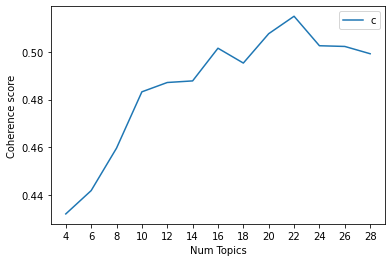

In [41]:
# Show coherence values graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(ticks=range(4,30,2))
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence peaks at 22 topics

### Create & Visualize Model with Optimal Number of Topics

In [278]:
optimal_model = joblib.load('stored_models/optimal_ldamallet_model_big.pkl')

#### LDA Mallet Model: 22 Topics

In [279]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.514920708296126


In [280]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model22_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.133438 -0.136513       1        1  4.192106
1      0.006915  0.163146       2        1  4.194466
2      0.138480 -0.069546       3        1  4.817759
3     -0.063720 -0.017377       4        1  5.363672
4      0.195799  0.169717       5        1  4.913114
5      0.178758 -0.037854       6        1  5.317013
6      0.081952 -0.248229       7        1  4.255241
7     -0.087550 -0.118886       8        1  3.866557
8     -0.186144  0.091490       9        1  4.892628
9     -0.026828  0.114689      10        1  3.488375
10    -0.127283 -0.193770      11        1  4.898971
11    -0.179226  0.053201      12        1  4.269464
12     0.141444  0.018441      13        1  6.129026
13    -0.120601  0.007271      14        1  4.636022
14     0.257752  0.073277      15        1  5.495806
15    -0.154081  0.154581      16        1  4.910807
16     0.099830  0.021269      17        1  4.761745
17    -0.064056 -0.016209      18        1  4.096129
18     0.080571  0.044302      19        1  3.133223
19    -0.118068  0.110348      20        1  4.073596
20     0.053577 -0.293666      21        1  4.850116
21     0.025918  0.110317      22        1  3.444163, topic_info=         Term           Freq          Total Category  logprob  loglift
80       data  126745.000000  126745.000000  Default  30.0000  30.0000
242     model   65841.000000   65841.000000  Default  29.0000  29.0000
933  function   29361.000000   29361.000000  Default  28.0000  28.0000
940     image   19343.000000   19343.000000  Default  27.0000  27.0000
572   feature   21095.000000   21095.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
794   similar     981.600363    6997.260538  Topic22  -5.2247   1.4044
335      show    1080.224516   14992.619119  Topic22  -5.1289   0.7381
253    number    1117.353650   19578.902912  Topic22  -5.0951   0.5050
275      post     899.220189    7013.017280  Topic22  -5.3123   1.3145
761    result     920.105343   18189.483116  Topic22  -5.2894   0.3844

[2136 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
3978       7  0.889839                 aaw
17740      5  0.982175              accent
17740     19  0.015842              accent
1555       2  0.008410              access
1555       3  0.132719              access
...      ...       ...                 ...
2285       2  1.002461              yearly
3608       2  0.988045  yearly_seasonality
1817      12  0.874649               ymean
17352     14  0.999671               yolov
1343       9  1.062167              youden

[5285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

Decent distribution but a fair amount of overlap; not a lot in the lower right-hand quadrant.

### Find the Dominant Topic in Each Document

In [281]:
pd.set_option('max_colwidth', 100)

In [282]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_bigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [283]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_bigrams)

df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [284]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.3904,"company, scientist, business, work, science, team, job, project, question, skill","[ultimate, guide, ace, code, interview, data, scientist, data, science, ultimate, guide, ace, co..."
1,1,18.0,0.3566,"video, time, car, face, system, signal, audio, detect, frame, sound","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,13.0,0.3174,"image, network, layer, deep, dataset, input, label, train, training, learn","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision, transformer_vit..."
3,3,0.0,0.2100,"column, table, data, panda, row, dataframe, query, sql, function, dataset","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,8.0,0.5239,"feature, algorithm, dataset, cluster, class, classification, classifier, number, score, predict","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


#### Find the most representative document for each topic

In [285]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [286]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
833,0.0,0.7505,"column, table, data, panda, row, dataframe, query, sql, function, dataset","[example, master, sql, comprehensive, practical, tutorial, example, master, sqlsql, programming,..."
8489,1.0,0.7221,"time, series, price, year, day, country, city, high, analysis, number","[mobility, change, south_africa, analysis, mobility, february, december, mobility, change, south..."
7518,2.0,0.7068,"pipeline, system, cloud, spark, run, store, application, process, platform, task","[understand, apache_spark, resource, task, management, apache, yarn, monitor, spark, understand,..."
8962,3.0,0.5422,"model, training, train, learning, prediction, dataset, set, machine, test, predict","[crossvalidation, testing, machine, learning, model, crossvalidation, crossvalidation, work, tec..."
3085,4.0,0.7245,"ai, system, human, research, people, world, bias, technology, risk, decision","[global, artificial_intelligence, race, strategic, balance, race, run, global, artificial_intell..."
9255,5.0,0.7185,"learn, science, machine, learning, article, project, field, book, language, start","[optimization, eye, pleasure, benchmark, test, function, single, objective, optimization, optimi..."
8238,6.0,0.6853,"create, api, app, google, application, web, service, build, deploy, click","[build, job, search, portal, django, user, app, part, second, part, deal, build, job, search, po..."
1660,7.0,0.6671,"plot, graph, visualization, create, node, show, chart, color, line, visualize","[ultimate, cheat_sheet, data, visualization, python, seaborn, library, great, resource, ultimate..."
8515,8.0,0.6625,"feature, algorithm, dataset, cluster, class, classification, classifier, number, score, predict","[mustknow, classification, metric, machine, learning, evaluate, classification, model, mustknow,..."
5510,9.0,0.7970,"state, game, action, player, algorithm, agent, play, team, reward, time","[bandit, algorithm, baby_robot, guide, reinforcement, learningbandit, algorithm, overview, recap..."


#### Explore Relationship Between Dominant Topic and Number of Citations

In [287]:
df.head()

,claps,text
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...


In [288]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.3904,"company, scientist, business, work, science, team, job, project, question, skill","[ultimate, guide, ace, code, interview, data, scientist, data, science, ultimate, guide, ace, co..."
1,1,18.0,0.3566,"video, time, car, face, system, signal, audio, detect, frame, sound","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,13.0,0.3174,"image, network, layer, deep, dataset, input, label, train, training, learn","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision, transformer_vit..."
3,3,0.0,0.2100,"column, table, data, panda, row, dataframe, query, sql, function, dataset","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,8.0,0.5239,"feature, algorithm, dataset, cluster, class, classification, classifier, number, score, predict","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


In [289]:
#merge on index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [290]:
combined_df.columns

Index(['claps', 'text', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text'],
      dtype='object')

In [291]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [292]:
combined_df.head()

,claps,text,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,14.0,0.3904,"company, scientist, business, work, science, team, job, project, question, skill"
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,18.0,0.3566,"video, time, car, face, system, signal, audio, detect, frame, sound"
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,13.0,0.3174,"image, network, layer, deep, dataset, input, label, train, training, learn"
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,0.0,0.2100,"column, table, data, panda, row, dataframe, query, sql, function, dataset"
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,8.0,0.5239,"feature, algorithm, dataset, cluster, class, classification, classifier, number, score, predict"


In [296]:
#the topics are not ordinal, so I will convert them to strings
combined_df22 = combined_df

combined_df22['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


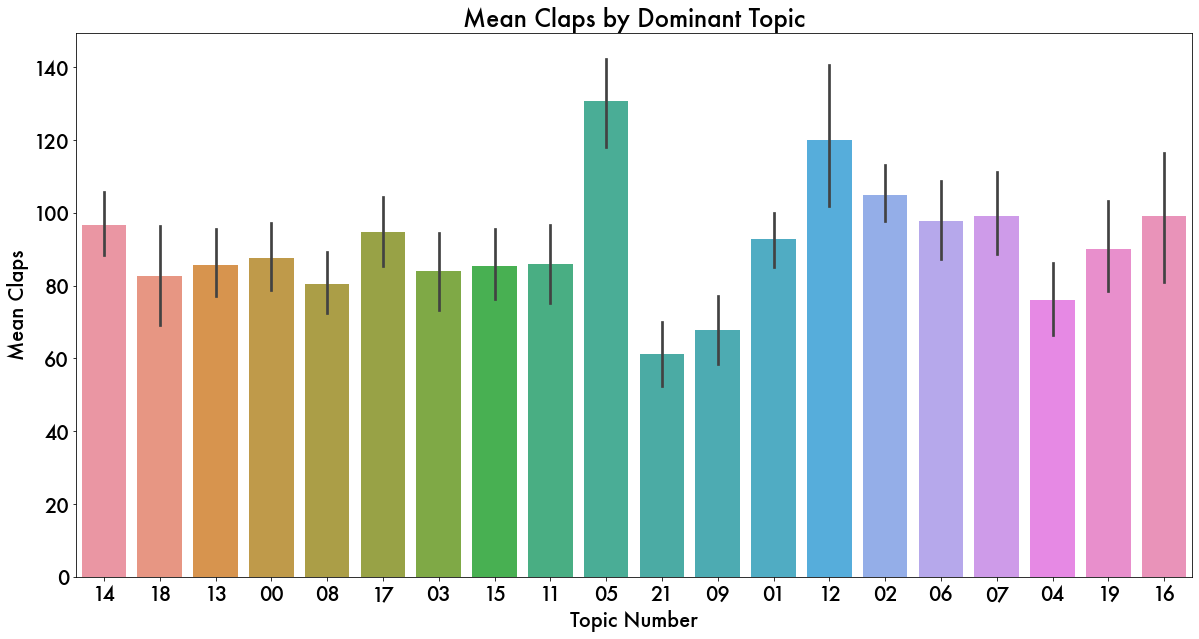

In [297]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df22, x='Dominant_Topic', y='claps');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_mean_claps_bigram_model22.jpg',  bbox_inches = "tight")

#### Model Claps by Topic

In [298]:
model_df = pd.get_dummies(combined_df22,columns=['Dominant_Topic'], drop_first=True)

In [299]:
model_df.columns

Index(['claps', 'text', 'Topic_Perc_Contrib', 'Keywords', 'Dominant_Topic_01',
       'Dominant_Topic_02', 'Dominant_Topic_03', 'Dominant_Topic_04',
       'Dominant_Topic_05', 'Dominant_Topic_06', 'Dominant_Topic_07',
       'Dominant_Topic_08', 'Dominant_Topic_09', 'Dominant_Topic_11',
       'Dominant_Topic_12', 'Dominant_Topic_13', 'Dominant_Topic_14',
       'Dominant_Topic_15', 'Dominant_Topic_16', 'Dominant_Topic_17',
       'Dominant_Topic_18', 'Dominant_Topic_19', 'Dominant_Topic_21'],
      dtype='object')

In [300]:
import statsmodels.api as sm

In [301]:
model_df.head()

,claps,text,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,...,Dominant_Topic_11,Dominant_Topic_12,Dominant_Topic_13,Dominant_Topic_14,Dominant_Topic_15,Dominant_Topic_16,Dominant_Topic_17,Dominant_Topic_18,Dominant_Topic_19,Dominant_Topic_21
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,0.3904,"company, scientist, business, work, science, team, job, project, question, skill",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,0.3566,"video, time, car, face, system, signal, audio, detect, frame, sound",0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,0.3174,"image, network, layer, deep, dataset, input, label, train, training, learn",0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,0.2100,"column, table, data, panda, row, dataframe, query, sql, function, dataset",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,0.5239,"feature, algorithm, dataset, cluster, class, classification, classifier, number, score, predict",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [302]:
X = model_df.drop(columns=['text','claps','Topic_Perc_Contrib','Keywords'])
X = sm.add_constant(X, prepend=True)
y = model_df['claps']

In [303]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claps   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     7.946
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.29e-22
Time:                        09:41:07   Log-Likelihood:                -57274.
No. Observations:                9290   AIC:                         1.146e+05
Df Residuals:                    9270   BIC:                         1.147e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                87.5188      4.998     17.512      0.000      77.722      97.315
Dominant_Topic_01     5.3090      6.343      0.837      0.403      -7.124      17.742
Dominant_Topic_02    17.3365      6.169      2.810      0.005       5.244      29.429
Dominant_Topic_03    -3.5953      8.003     -0.449      0.653     -19.284      12.093
Dominant_Topic_04   -11.5836      7.623     -1.520      0.129     -26.526       3.359
Dominant_Topic_05    43.2019      6.994      6.177      0.000      29.492      56.912
Dominant_Topic_06    10.1466      7.129      1.423      0.155      -3.828      24.121
Dominant_Topic_07    11.6782      7.289      1.602      0.109      -2.609      25.966
Dominant_Topic_08    -6.9494      6.994     -0.994      0.320     -20.659       6.760
Dominant_Topic_09   -19.5842      8.147     -2.404      0.016     -35.553      -3.615
Dominant_Topic_11    -1.6032      7.748     -0.207      0.836     -16.791      13.585
Dominant_Topic_12    32.5932      8.950      3.642      0.000      15.049      50.138
Dominant_Topic_13    -1.8208      7.032     -0.259      0.796     -15.605      11.963
Dominant_Topic_14     9.1899      6.758      1.360      0.174      -4.057      22.437
Dominant_Topic_15    -2.1355      7.524     -0.284      0.777     -16.884      12.613
Dominant_Topic_16    11.7100     10.574      1.107      0.268      -9.018      32.438
Dominant_Topic_17     7.2820      7.068      1.030      0.303      -6.572      21.136
Dominant_Topic_18    -4.9484      8.613     -0.575      0.566     -21.832      11.935
Dominant_Topic_19     2.5152      9.029      0.279      0.781     -15.183      20.213
Dominant_Topic_21   -26.1866      8.340     -3.140      0.002     -42.536      -9.838
==============================================================================
Omnibus:                     4569.122   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25939.597
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                       9.675   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There are several repeated keywords across topics which may be an indication that there are too many topics. I will also visualize and run the regression with another local coherence peak value with a lower number of topics. 

### Create & Visualize Model with Optimal Number of Topics

#### LDA Mallet Model: 16 Topics

In [304]:
optimal_model = joblib.load('stored_models/ldamallet_model16_big.pkl')

In [305]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5015203148743821


In [306]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model16_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.188096 -0.056744       1        1  6.869610
1     -0.034437 -0.096823       2        1  4.833512
2     -0.255980 -0.137046       3        1  5.934346
3      0.091536  0.180473       4        1  5.914677
4      0.082151  0.051869       5        1  5.196251
5     -0.091024  0.178304       6        1  9.130897
6     -0.071010  0.212562       7        1  7.122526
7      0.133780 -0.063506       8        1  7.356115
8      0.110740 -0.106591       9        1  6.815358
9     -0.030923 -0.213431      10        1  6.570925
10     0.042623 -0.034005      11        1  5.717232
11    -0.236160 -0.076257      12        1  5.847669
12    -0.181895  0.045669      13        1  5.415326
13     0.012858  0.233189      14        1  6.718466
14     0.203697 -0.062711      15        1  5.359124
15     0.035946 -0.054952      16        1  5.197966, topic_info=             Term           Freq          Total Category  logprob  loglift
80           data  126931.000000  126931.000000  Default  30.0000  30.0000
242         model   65903.000000   65903.000000  Default  29.0000  29.0000
933      function   29218.000000   29218.000000  Default  28.0000  28.0000
50           code   26639.000000   26639.000000  Default  27.0000  27.0000
940         image   19375.000000   19375.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
292      question    1428.487726    9404.558230  Topic16  -5.2611   1.0723
761        result    1544.002041   18183.135322  Topic16  -5.1833   0.4908
1205     generate    1353.003266    7792.865383  Topic16  -5.3153   1.2060
183   information    1373.589972   10948.127276  Topic16  -5.3002   0.8812
150          give    1315.260908   16053.934607  Topic16  -5.3436   0.4550

[1558 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1555       3  0.423834   access
1555       4  0.027628   access
1555       7  0.113582   access
1555      10  0.126065   access
1555      13  0.204856   access
...      ...       ...      ...
1817       1  0.879270    ymean
12778      9  0.999393     yolo
2906       2  0.868311    ¹note
2907       9  0.894854      ¹⁰⁰
2908       6  0.886952  ⁴define

[3444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

### Find the Dominant Topic in Each Document

In [307]:
pd.set_option('max_colwidth', 100)

In [308]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_bigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [309]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_bigrams)

df_dominant_topic =pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [310]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5328,"science, data, learn, work, scientist, project, job, good, time, question","[ultimate, guide, ace, code, interview, data, scientist, data, science, ultimate, guide, ace, co..."
1,1,15.0,0.3201,"word, text, language, topic, document, sentence, model, nlp, task, transformer","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,8.0,0.4144,"image, layer, network, input, deep, neural_network, output, training, function, learn","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision, transformer_vit..."
3,3,9.0,0.2463,"function, column, list, method, table, python, object, number, return, row","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,14.0,0.5120,"algorithm, cluster, matrix, class, number, vector, point, find, metric, distance","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


#### Find the most representative document for each topic

In [311]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [312]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
329,0.0,0.8789,"probability, distribution, variable, sample, test, function, number, give, random, error","[ultimate, guide, hypothesis, testing, confidence_interval, different, get, ultimate, guide, hyp..."
8930,1.0,0.6618,"plot, graph, visualization, node, create, show, map, data, chart, color","[plot, chart, matplotlib, ggplot, learn, create, plot, chart, matplotlib, ggplot, play, lot, ggp..."
8009,2.0,0.7287,"file, create, app, api, follow, run, database, click, web, add","[set, public, minecraft_server, simple, step, guide, create, world, set, public, minecraft_serve..."
8489,3.0,0.7437,"year, time, day, high, price, number, analysis, people, group, month","[mobility, change, south_africa, analysis, mobility, february, december, mobility, change, south..."
5510,4.0,0.8053,"state, time, game, action, problem, player, algorithm, play, good, team","[bandit, algorithm, baby_robot, guide, reinforcement, learningbandit, algorithm, overview, recap..."
1540,5.0,0.8014,"science, data, learn, work, scientist, project, job, good, time, question","[develop, communication, skill, technical, job, learn, effectively, communicate, develop, commun..."
3034,6.0,0.7648,"data, business, company, product, team, customer, analytic, tool, process, user","[ultimate, data, observability, checklist, data, observability, set, bunch, ultimate, data, obse..."
4982,7.0,0.7057,"model, feature, training, learning, prediction, machine, predict, train, dataset, set","[advanced, ensemble, learning, technique, ensemble, art, scienceadvanced, ensemble, learning, te..."
7608,8.0,0.7992,"image, layer, network, input, deep, neural_network, output, training, function, learn","[practical, generative, deep, image, inpainte, approach, review, freeform, image, inpainte, gate..."
8693,9.0,0.8756,"function, column, list, method, table, python, object, number, return, row","[useful, thing, know, python, extremely, useful, function, expression, know, python, useful, thi..."


#### Explore Relationship Between Dominant Topic and Number of Citations

In [313]:
df.head()

,claps,text
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...


In [314]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5328,"science, data, learn, work, scientist, project, job, good, time, question","[ultimate, guide, ace, code, interview, data, scientist, data, science, ultimate, guide, ace, co..."
1,1,15.0,0.3201,"word, text, language, topic, document, sentence, model, nlp, task, transformer","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,8.0,0.4144,"image, layer, network, input, deep, neural_network, output, training, function, learn","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision, transformer_vit..."
3,3,9.0,0.2463,"function, column, list, method, table, python, object, number, return, row","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,14.0,0.5120,"algorithm, cluster, matrix, class, number, vector, point, find, metric, distance","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


In [315]:
#merge on index
combined_df = pd.DataFrame()
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [316]:
combined_df.columns

Index(['claps', 'text', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text'],
      dtype='object')

In [317]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [318]:
combined_df.head()

,claps,text,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,5.0,0.5328,"science, data, learn, work, scientist, project, job, good, time, question"
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,15.0,0.3201,"word, text, language, topic, document, sentence, model, nlp, task, transformer"
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,8.0,0.4144,"image, layer, network, input, deep, neural_network, output, training, function, learn"
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,9.0,0.2463,"function, column, list, method, table, python, object, number, return, row"
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,14.0,0.5120,"algorithm, cluster, matrix, class, number, vector, point, find, metric, distance"


In [319]:
#the topics are not ordinal, so I will convert them to strings
combined_df16 = combined_df

combined_df16['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


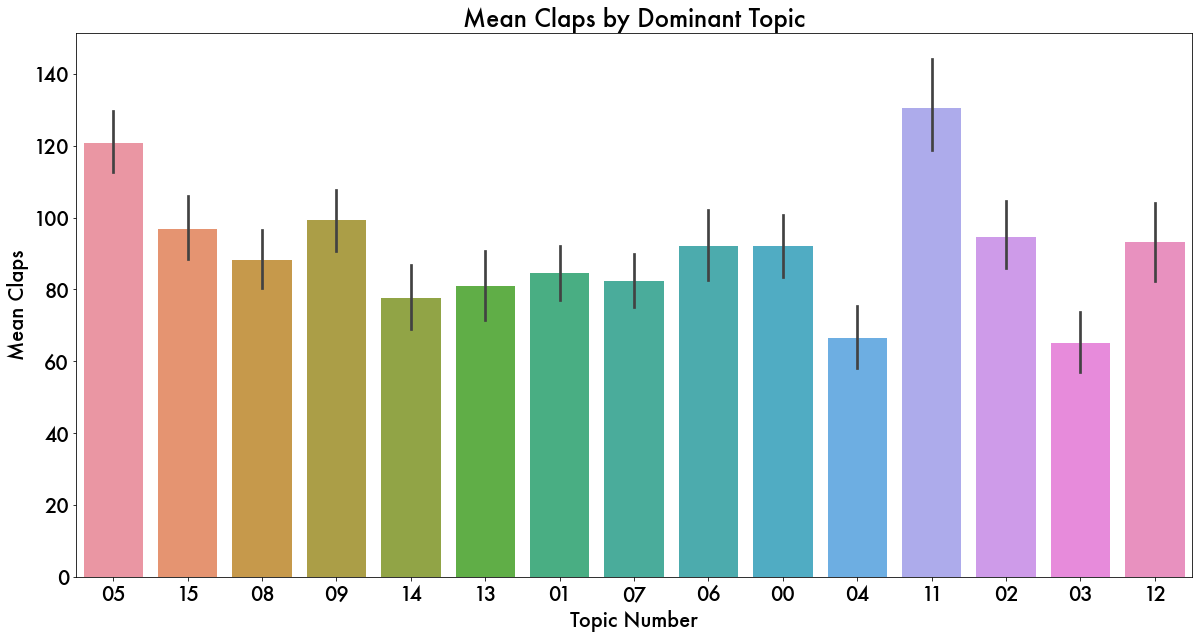

In [320]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df16, x='Dominant_Topic', y='claps');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_mean_claps_bigram_model_16.jpg',  bbox_inches = "tight")

#### Model Claps by Topic

In [321]:
model_df = pd.get_dummies(combined_df16,columns=['Dominant_Topic'], drop_first=True)

In [322]:
model_df.columns

Index(['claps', 'text', 'Topic_Perc_Contrib', 'Keywords', 'Dominant_Topic_01',
       'Dominant_Topic_02', 'Dominant_Topic_03', 'Dominant_Topic_04',
       'Dominant_Topic_05', 'Dominant_Topic_06', 'Dominant_Topic_07',
       'Dominant_Topic_08', 'Dominant_Topic_09', 'Dominant_Topic_11',
       'Dominant_Topic_12', 'Dominant_Topic_13', 'Dominant_Topic_14',
       'Dominant_Topic_15'],
      dtype='object')

In [323]:
import statsmodels.api as sm

In [324]:
model_df.head()

,claps,text,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,Dominant_Topic_07,Dominant_Topic_08,Dominant_Topic_09,Dominant_Topic_11,Dominant_Topic_12,Dominant_Topic_13,Dominant_Topic_14,Dominant_Topic_15
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,0.5328,"science, data, learn, work, scientist, project, job, good, time, question",0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,0.3201,"word, text, language, topic, document, sentence, model, nlp, task, transformer",0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,0.4144,"image, layer, network, input, deep, neural_network, output, training, function, learn",0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,0.2463,"function, column, list, method, table, python, object, number, return, row",0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,0.5120,"algorithm, cluster, matrix, class, number, vector, point, find, metric, distance",0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [325]:
X = model_df.drop(columns=['text','claps','Topic_Perc_Contrib','Keywords'])
X = sm.add_constant(X, prepend=True)
y = model_df['claps']

In [326]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claps   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     13.42
Date:                Tue, 11 May 2021   Prob (F-statistic):           3.66e-32
Time:                        09:42:41   Log-Likelihood:                -57256.
No. Observations:                9290   AIC:                         1.145e+05
Df Residuals:                    9275   BIC:                         1.146e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                92.1658      4.830     19.081      0.000      82.698     101.634
Dominant_Topic_01    -7.6977      6.199     -1.242      0.214     -19.850       4.454
Dominant_Topic_02     2.5431      6.636      0.383      0.702     -10.464      15.550
Dominant_Topic_03   -27.0743      7.175     -3.774      0.000     -41.138     -13.011
Dominant_Topic_04   -25.7585      7.456     -3.455      0.001     -40.374     -11.143
Dominant_Topic_05    28.6396      6.044      4.738      0.000      16.792      40.487
Dominant_Topic_06    -0.0117      6.709     -0.002      0.999     -13.163      13.140
Dominant_Topic_07    -9.8223      6.676     -1.471      0.141     -22.908       3.263
Dominant_Topic_08    -4.0107      6.304     -0.636      0.525     -16.368       8.347
Dominant_Topic_09     7.0494      6.448      1.093      0.274      -5.590      19.689
Dominant_Topic_11    38.3209      7.106      5.393      0.000      24.392      52.250
Dominant_Topic_12     1.0012      6.939      0.144      0.885     -12.601      14.603
Dominant_Topic_13   -11.3166      7.118     -1.590      0.112     -25.269       2.636
Dominant_Topic_14   -14.6726      7.298     -2.011      0.044     -28.978      -0.367
Dominant_Topic_15     4.6459      6.694      0.694      0.488      -8.475      17.767
==============================================================================
Omnibus:                     4587.177   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26262.576
Skew:                           2.378   Prob(JB):                         0.00
Kurtosis:                       9.726   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3,4,5,11